In [2]:
import numpy as np
import warnings
import keras
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

from matplotlib import pyplot as plt


Using TensorFlow backend.


In [3]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
def VGG16(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [5]:
model = VGG16(include_top=True, weights='imagenet')

In [6]:
#HOME_DIR = "/home/avkash/tools/projects/keras_work/"
HOME_DIR = "/Users/avkashchauhan/learn/deepwater"

In [ ]:
#Saving model
model.save_weights(HOME_DIR + 'vgg16_weights.h5')
model.save( HOME_DIR  + 'vgg16_save.HDF5')

In [ ]:
# serialize model to JSON
model_json_file = HOME_DIR +  'vgg16_model.json'
model_json = model.to_json()
with open(model_json_file, "w") as json_file:
    json_file.write(model_json)

In [7]:
#img_path = '/home/avkash/tools/elephant.jpg'
img_path = "/Users/avkashchauhan/learn/deepwater/cat.png"
#img_path = "/Users/avkashchauhan/learn/deepwater/dog-bw.jpg"

img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(len(x.shape))
print(x.shape[2])
print('Input image shape:', x.shape)

4
224
Input image shape: (1, 224, 224, 3)


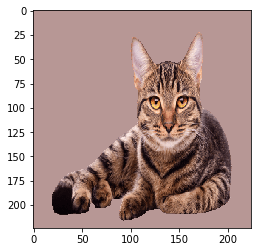

In [8]:
plt.imshow(img) # Note: Sometimes you need to call pyplot.show() to display the image
# Try this too -- plt.imshow(img, aspect = 'auto')
plt.show()

In [9]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n02123045', 'tabby', 0.48707217), ('n02124075', 'Egyptian_cat', 0.35387233), ('n02123159', 'tiger_cat', 0.12616262), ('n02127052', 'lynx', 0.0034919882), ('n04040759', 'radiator', 0.0020587537)]]


In [ ]:
from keras.models import model_from_json

# Loading saved model for testing:
print("Loading model from disk..1")
# load json and create model
saved_model_json_file = HOME_DIR + 'vgg16_model.json'
json_file = open(saved_model_json_file, 'r')
loaded_model_json = json_file.read()
#json_file.close()

#print(loaded_model_json)

print("Loading model from disk..2")

loaded_model = model_from_json(loaded_model_json)
#print(loaded_model)
print("Loading model from disk..3")
# load weights into new model
saved_model_weight_file = HOME_DIR + 'vgg16_weights.h5'

loaded_model.load_weights(saved_model_weight_file)

print("The model is loaded from disk..")
print("Now Compiling model..")
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print("The Model is compiled..")
print(loaded_model.summary())


In [ ]:
# Predicting using loaded model
preds = loaded_model.predict(x)
print('Predicted:', decode_predictions(preds))
preds_prob=preds[0][1]
print(preds_prob)
#(inID, label) = decode_predictions(preds)[0]
#from keras import np_utils
#y_classes = np_utils.probas_to_classes(preds)
#print(y_classes)

In [ ]:
# TEMP
model = loaded_model

In [ ]:
#from keras.utils.visualize_util import plot
#from keras.utils.vis_utils import plot
model_file  = HOME_DIR + 'model-summary.png'
#graph = plot(self.model,to_file=model_file, show_shapes=True)

#from keras.utils import plot_model
#plot_model(model, to_file=model_file)

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.get_weights()

In [ ]:
def getmodelSummary(model):
    print("Generating model summary for the model....")
    return model.summary()

In [ ]:
# Model Summary
getmodelSummary(model)

In [ ]:
# our image is now represented by a NumPy array of shape (3, 224, 224),
# but we need to expand the dimensions to be (1, 3, 224, 224) so we can
# pass it through the network -- we'll also preprocess the image by
# subtracting the mean RGB pixel intensity from the ImageNet dataset
# ---------------------------
def browseInputImage(imagePath):
    img = image.load_img(imagePath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print(img.size)
    plt.imshow(img, cmap = 'gray') # Note: Sometimes you need to call pyplot.show() to display the image
    # Try this too -- plt.imshow(img, aspect = 'auto')
    plt.show()

In [ ]:
browseInputImage(img_path)

In [10]:
len(model.layers)

23

In [11]:
def getLayerInfo(layerId, activationId):
    temp = 0
    layer_info= model.layers[layerId].get_config()
    #print layer_info
    layer_name=layer_info['name']
    try:
        temp = layer_info['filters']
        layer_filters = temp 
    except Exception:
        layer_filters = "There are no filters in this layer"
        # do nothing
    input_shape=model.layers[layerId].input_shape 
    output_shape=model.layers[layerId].output_shape
    layer_param=model.layers[layerId].count_params()
    print('Layer Id : ' + str(layerId))
    print('Layer Name : ' + layer_name)
    print('Layer filters : ' + str(layer_filters))
    print('Layer Number : ' + str(layerId) )
    #print('Layer Type : ' + model.layers[layerId].type )
    print('Layer Input Shape : ' + str(input_shape))
    print('Layer output shape :' + str(output_shape))
    print('Num of Parameters :' + str(layer_param))
    
    output_shape = np.shape(activationId[0])
    featuremap_size = np.shape(activationId[0][0][0])
    featuremaps_num = (np.shape(activationId[0][0][0]))[1]
    print('Output Shape (activationId) : ' + str(output_shape))
    print('Featuremap Size : ' + str(featuremap_size))
    print('Featuremaps Count: ' + str(featuremaps_num))

In [12]:
def get_activation_obj(model, layer_idx, X_batch):
    activation_temp = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    #print(activation_temp)
    return activation_temp([X_batch,0])

In [33]:
from numpy import array
#print img.size
#plt.imshow(img)  ## we have 224x224x3 image
img_temp = array(img).reshape(1, 224,224,3)
#plt.imshow(img_temp)
#plt.show()
#print img_temp.size # This is flatten image
layer_id_tmp = 2
## Note: If layer type is flatten or dense then there are no feature maps
activations_x = get_activation_obj(model, layer_id_tmp, img_temp)
getLayerInfo(layer_id_tmp,activations_x)

Layer Id : 2
Layer Name : block1_conv2
Layer filters : 64
Layer Number : 2
Layer Input Shape : (None, 224, 224, 64)
Layer output shape :(None, 224, 224, 64)
Num of Parameters :36928
Output Shape (activationId) : (1, 224, 224, 64)
Featuremap Size : (224, 64)
Featuremaps Count: 64


In [27]:
def display_all_featuremaps(activationObj, showOnly):
    output_shape = np.shape(activations_x[0])
    f_map_total = (np.shape(activations_x[0][0]))[2]
    if len(output_shape)==2:
        fig=plt.figure(figsize=(16,16))
        plt.imshow(activationObj[0].T,cmap='gray')
        plt.show()
        #plt.savefig("featuremaps-layer-{}".format(self.layer) + '.png')
    else:
        fig=plt.figure(figsize=(16,16))
        subplot_num=int(np.ceil(np.sqrt(f_map_total)))
        print("Subplot Num : " + str(subplot_num)) 
        #for i in range(int(featuremaps_total)): 
        displayLimit = f_map_total
        if showOnly > 0:
            displayLimit = showOnly
        for i in range(int(showOnly)): 
            ax = fig.add_subplot(subplot_num, subplot_num, i+1)
            #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
            activationObj_local = activationObj[0]
            activationObj_local = activationObj_local[0]
            ##print("xxx " + str(activationObj_local.shape))
            im_t = activationObj_local[0:,0:,i]
            ##print("Printing Image Shape : " + str(im_t.shape))
            ax.imshow(im_t) #,cmap='gray')
            #plt.xticks(np.array([]))
            #plt.yticks(np.array([]))
            #plt.tight_layout()
        plt.show()

        #fig.savefig("featuremaps-layer-{}".format(self.layer) + '.png')

Showing total featuremaps: 512
Output Shape: (1, 7, 7, 512)
Subplot Num : 23


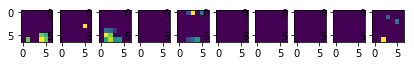

In [29]:
featuremaps_total_123 = (np.shape(activations_x[0][0]))[2]
print("Showing total featuremaps: " + str(featuremaps_total_123))
output_shape_123 = np.shape(activations_x[0])
print("Output Shape: " + str(output_shape_123))
#print(activations_x)
display_all_featuremaps(activations_x, 10)

In [30]:
def individualFeatureMap(featureMapNumber,activationObj):
    map_num = featureMapNumber
    fig=plt.figure(figsize=(8,8))
    activationObj_local = activationObj[0]
    activationObj_local = activationObj_local[0]
    im_temp = activationObj_local[0:,0:,map_num] ##### ----- We need to pass i here instead of number
    print(im_temp.shape)
    plt.imshow(im_temp) # ,cmap = 'gray')
    plt.show()

(224, 224)


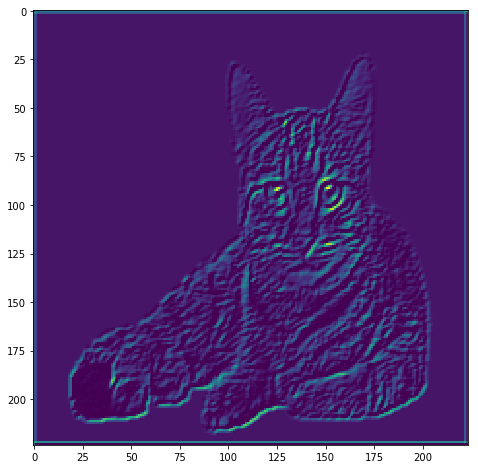

In [34]:
individualFeatureMap(10,activations_x)  # Pass any feature map number here

In [ ]:
# https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
def get_activations_X(model, model_inputs, print_shape_only=False, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [ ]:
# When you have 1 sample use - img_temp[0:1]
all_activation = get_activations_X(model,img_temp[0:1], print_shape_only=True)

In [ ]:
#all_activation_1layer = get_activations_X(model,img_temp[0:1], print_shape_only=True, layer_name= "input_1")
all_activation_1layer = get_activations_X(model,img_temp[0:1],layer_name= "block4_conv3") # "input_1"

In [ ]:
print(np.shape(all_activation_1layer[0]))
print(np.shape(all_activation_1layer[0]))[0]
print(np.shape(all_activation_1layer[0]))[1]
print(np.shape(all_activation_1layer[0]))[2]
print(np.shape(all_activation_1layer[0]))[3]
print("------1")
print(np.shape(all_activation_1layer[0][0]))
print(np.shape(all_activation_1layer[0][0]))[0]
print(np.shape(all_activation_1layer[0][0]))[1]
print(np.shape(all_activation_1layer[0][0]))[2]
print("------2")
print(np.shape(all_activation_1layer[0][0][0]))
print(np.shape(all_activation_1layer[0][0][0]))[0]
print(np.shape(all_activation_1layer[0][0][0]))[1]
print("------3")
print(np.shape(all_activation_1layer[0][0][0][0]))
print(np.shape(all_activation_1layer[0][0][0][0]))[0]
print("------Exo")

print(np.shape(all_activation_1layer[0]))[1:3]

In [ ]:
np.shape(all_activation_1layer[0])[1:3]

In [ ]:
all_activation_1layer[0][1:3]

In [ ]:
np.shape(all_activation_1layer[0])[1]

In [ ]:
print(all_activation_1layer[0][0:,0][0].shape)
all_activation_1layer[0][0:224,:224][1:,1].shape

In [ ]:
all_activation_1layer[0].shape

In [ ]:
x_obj = all_activation_1layer[0]

In [ ]:
x_obj = x_obj[0]

In [ ]:
x_obj.shape

In [ ]:
#test[0:, 1:(ncol - 1)]
x_obj[0:,0:,1].shape
#plt.imshow(x_obj)
#plt.show()